## the script needs cuda support to accelerate the encoding process!

In [1]:
rand_nobs = 50

In [2]:
import os
import sys

sys.path.append('../')


In [3]:
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [4]:
import torch
from datasets import MetaData

dataset_ts_path = '/home/lizhuoyuan/datasets/shallow_water/cached_meta_ts.pt'
dataset_ts: MetaData = torch.load(dataset_ts_path)
dataset_ts.trajs[0].shape

torch.Size([240, 128, 64, 2])

In [5]:
import logging
logger = logging.getLogger()

In [6]:
import hydra
from hydra import compose, initialize
from hydra.core.config_store import ConfigStore
from omegaconf import OmegaConf

from configs.pretrain.pretrain_conf_schema import PreTrainConfig
from configs.conf_schema import EDConfig, LDConfig, UEConfig, DatasetConfig
from metrics import get_metrics
from common import create_logger, set_seed, transform_state_dict

set_seed(2357)

cs = ConfigStore.instance()
cs.store(name="pretrain_schema", node=PreTrainConfig)
cs.store(group="encoder_decoder", name="encoder_decoder_schema", node=EDConfig)
cs.store(name="dataset_schema", group='dataset', node=DatasetConfig)

with initialize(config_path='../configs/pretrain', version_base='1.2'):
    cfg1 = compose(config_name='config', overrides=[
        "encoder_decoder=ablation/cae/h32_k5",
    ])
    cfg2 = compose(config_name='config', overrides=[
        "encoder_decoder=ablation/aeflow/b4_k5",
    ])
    cfg3 = compose(config_name='config', overrides=[
        "encoder_decoder=default_sinr_v11",
    ])

In [7]:
def conf_prepare(cfg: PreTrainConfig):

    cfg.encoder_decoder.arch_params.state_channels = cfg.dataset.snapshot_shape[-1]
    cfg.encoder_decoder.arch_params.state_size = cfg.dataset.snapshot_shape[:-1]
    cfg.ckpt_path = os.path.join('..', cfg.ckpt_path)


conf_prepare(cfg1)
conf_prepare(cfg2)
conf_prepare(cfg3)

print(OmegaConf.to_yaml(cfg1))

name: ${dataset.name}_${encoder_decoder.name}
phase: pretrain
seed: 2357
num_gpus: 0
master_port: 23571
ckpt_path: ../../ckpts/pretrain/sw_CAE_h32_k5.pt
nepochs: 10000
bs: ${encoder_decoder.training_params.bs}
eval_freq: 10
mix_precision: false
dataset:
  name: sw
  root_path: /home/lizhuoyuan/datasets/shallow_water
  snapshot_shape:
  - 128
  - 64
  - 2
  read_cache: true
  normalize: true
  normalize_mean: null
  normalize_std: null
  window_width: 10
  offgrid: false
encoder_decoder:
  model_name: CAE
  cfg_name: h32_k5
  name: ${encoder_decoder.model_name}_${encoder_decoder.cfg_name}
  latent_dim: 1024
  need_train: true
  need_cache: false
  arch_params:
    hidden_channels: 32
    latent_channels: 8
    kernel_size: 5
    padding_type:
    - circular
    - replicate
    nresblocks: null
    state_size:
    - 128
    - 64
    state_channels: 2
    coord_channels: null
    code_dim: null
    hidden_dim: null
    depth: 3
    max_freq: null
    inner_loop_loss_fn: null
    inner_loo

In [8]:
from datasets import load_dataset

dataset_class = load_dataset(logger, cfg=cfg1.dataset)
dataset_tr = dataset_class.get_metadata('tr')
dataset_va = dataset_class.get_metadata('va')
dataset_ts = dataset_class.get_metadata('ts')

In [9]:
h_gt = dataset_va.trajs[0, 0, ..., 0]
v_gt = dataset_va.trajs[0, 0, ..., 1]
print(f'{h_gt.shape=}, {v_gt.shape=}')

h_gt.shape=torch.Size([128, 64]), v_gt.shape=torch.Size([128, 64])


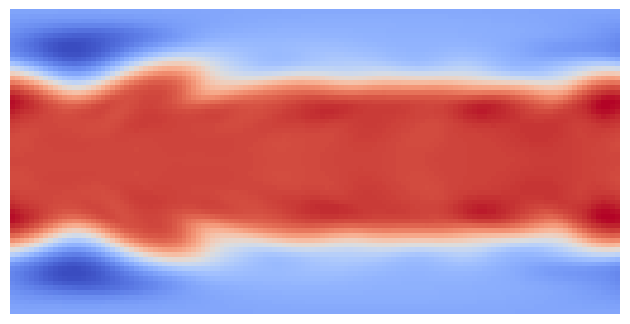

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt
save_path = f'offgrid/{rand_nobs=}'
os.makedirs(save_path,exist_ok=True)
plt.imshow(h_gt.T, origin='lower', cmap='coolwarm')
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'height_true.pdf'))

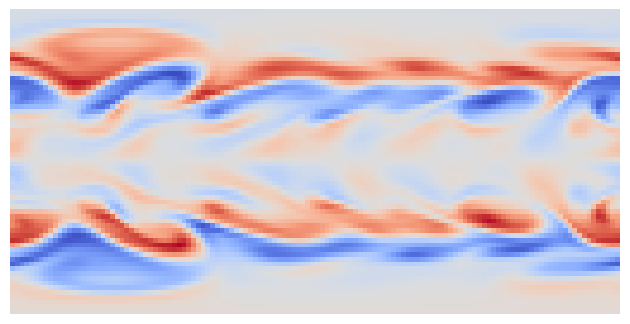

In [11]:
plt.imshow(v_gt.T, origin='lower', cmap='coolwarm')
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'vorticity_true.pdf'))

In [12]:
import math
import numpy as np


rand_num = rand_nobs
rand_idxs = np.random.permutation(128 * 64)[:rand_num]
mask = torch.zeros(128 * 64, dtype=torch.int8)
mask[rand_idxs] = 1
mask = mask.reshape(128, 64)

interpolate with scipy

In [13]:
from scipy import interpolate

coord_latlon = dataset_va.coords['coord_latlon']


def interpolate_mask(image: torch.Tensor, mask: torch.Tensor, **kwargs):

    if isinstance(image, torch.Tensor):
        image = image.numpy()
    if isinstance(mask, torch.Tensor):
        mask = mask.numpy()
    mask = mask.copy()
    masked_image = image.copy()
    masked_image[mask == 0] = np.nan
    masked_coords_ang = coord_latlon[mask == 1]

    values = masked_image[~np.isnan(masked_image)]

    # Perform griddata interpolation
    rbf = interpolate.RBFInterpolator(masked_coords_ang, values, **kwargs)
    interpolated_3dimage = rbf(coord_latlon.reshape(-1, 2)).reshape(*coord_latlon.shape[:-1])

    return interpolated_3dimage


def plot_mask(image: torch.Tensor, mask: torch.Tensor):

    cmap = matplotlib.colormaps['coolwarm']
    cmap.set_bad(color='gray')

    mask = mask.numpy().copy()
    masked_image = image.numpy().copy()
    masked_image[mask == 0] = np.nan

    plt.imshow(masked_image, cmap=cmap, interpolation='nearest')

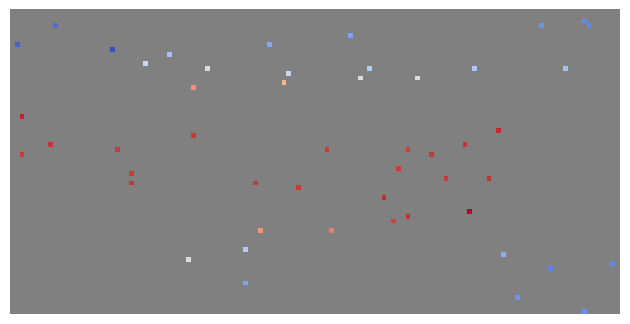

In [14]:
import matplotlib

cmap = matplotlib.colormaps['coolwarm']
cmap.set_bad(color='gray')

mask_np = mask.numpy().copy()
masked_image = h_gt.numpy().copy()
masked_image[mask_np == 0] = np.nan

# fig, axs = plt.subplots(1, len(kernels) + 1, figsize=(20, 5))

plt.imshow(masked_image.T, origin='lower', cmap=cmap, interpolation='nearest')
# plt.title(f'masked input ({rand_ratio*100}% observed)')
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'masked_height.pdf'), bbox_inches='tight')

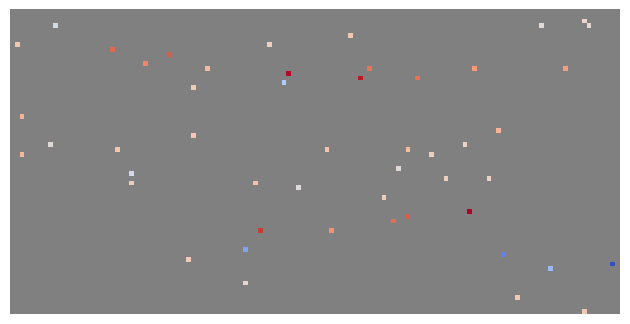

In [15]:
cmap = matplotlib.colormaps['coolwarm']
cmap.set_bad(color='gray')

mask_np = mask.numpy().copy()
masked_image = v_gt.numpy().copy()
masked_image[mask_np == 0] = np.nan

# fig, axs = plt.subplots(1, len(kernels) + 1, figsize=(20, 5))

plt.imshow(masked_image.T, origin='lower', cmap=cmap, interpolation='nearest')
# plt.title(f'masked input ({rand_ratio*100}% observed)')
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'masked_vorticity.pdf'), bbox_inches='tight')

cubic: abs diff: 0.3744


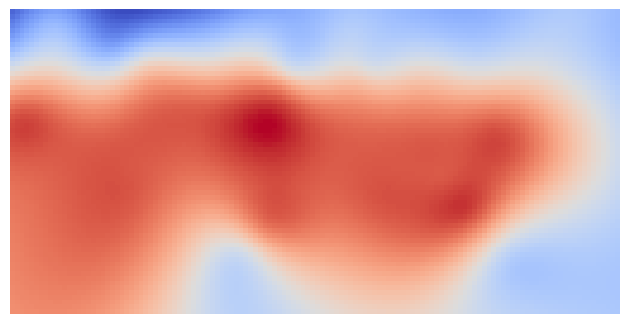

In [16]:
kernel = 'cubic'
interpolated_image = interpolate_mask(h_gt, mask, kernel=kernel)
plt.imshow(interpolated_image.T, origin='lower', cmap='coolwarm')
plt.axis('off')
plt.tight_layout()
diff = np.mean(np.abs(interpolated_image - h_gt.detach().cpu().numpy()))
print(kernel + ': abs diff: {:.4f}'.format(diff))
plt.savefig(os.path.join(save_path, 'interpolated_height.pdf'))

cubic  abs diff: 1.6830


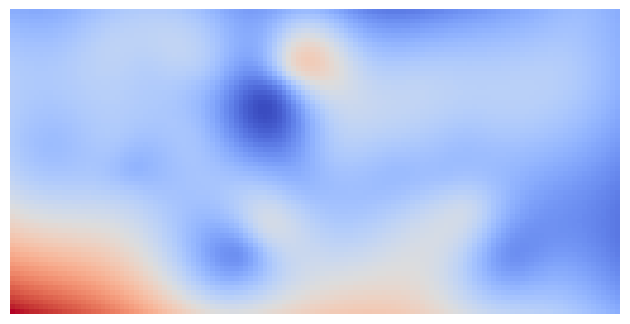

In [17]:
kernel = 'cubic'
interpolated_image = interpolate_mask(v_gt, mask, kernel=kernel)
plt.imshow(interpolated_image.T, origin='lower', cmap='coolwarm')
plt.axis('off')
plt.tight_layout()
diff = np.mean(np.abs(interpolated_image - v_gt.detach().cpu().numpy()))
print(kernel + '  abs diff: {:.4f}'.format(diff))
plt.savefig(os.path.join(save_path, 'interpolated_vorticity.pdf'))

In [18]:
interpolated_height = interpolate_mask(h_gt, mask, kernel='cubic')
interpolated_vorticity = interpolate_mask(v_gt, mask, kernel='cubic')

x_interp = torch.stack([torch.from_numpy(interpolated_height),
                        torch.from_numpy(interpolated_vorticity)], dim=-1)
x_interp.shape

torch.Size([128, 64, 2])

In [19]:
from components import EncoderDecoder, LatentDynamics, UncertaintyEst
from components import get_encoder_decoder, get_latent_dynamics, get_uncertainty_est

In [20]:
def get_model(cfg: PreTrainConfig):
    if cfg.encoder_decoder.need_cache:
        masked_wmse_fn = get_metrics(name='weighted', phi_theta=coord_latlon, mask=mask)
    else:
        masked_wmse_fn = None

    model: EncoderDecoder = get_encoder_decoder(logger,
                                                name=cfg.encoder_decoder.model_name,
                                                loss_fn_inner_loop=masked_wmse_fn,
                                                **cfg.encoder_decoder.arch_params)
    ckpt = torch.load(cfg.ckpt_path, map_location='cuda')
    model.load_state_dict(transform_state_dict(ckpt['ed']))

    return model

In [21]:
cae = get_model(cfg1)
aeflow = get_model(cfg2)
sinr = get_model(cfg3)


In [22]:
x_interp = x_interp.cuda()

# CAE
cae = cae.cuda()
cae.eval()
x_rec_cae = cae.decode(cae.encode(x_interp.clone().float()))

# AEFlow
aeflow = aeflow.cuda()
aeflow.eval()
x_rec_aeflow = aeflow.decode(aeflow.encode(x_interp.clone().float()))

x_rec_cae.shape, x_rec_aeflow.shape

(torch.Size([128, 64, 2]), torch.Size([128, 64, 2]))

In [23]:
# SINR
sinr = sinr.cuda()
sinr.eval()

x0 = torch.stack([h_gt, v_gt], dim=-1).cuda()
z0 = torch.zeros(400).to(x0)
coord_latlon = coord_latlon.cuda()
z = sinr.encode(x=x0, coord_latlon=coord_latlon.cuda(), z0=z0, optim_eval_max_inner_loops=1000)
x_rec_sinr = sinr.decode(z=z, coord_latlon=coord_latlon)

In [24]:
xx_t = torch.stack([h_gt, v_gt], dim=-1)

CAE reconstruction (height) avg. absolute error: 0.7460


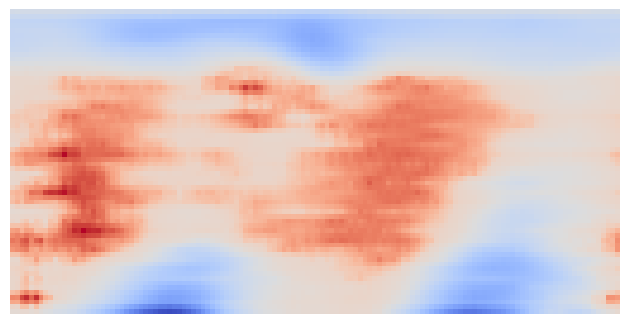

In [25]:
plt.imshow(x_rec_cae[..., 0].detach().cpu().numpy().T, origin='lower', cmap='coolwarm')
plt.axis('off')
plt.tight_layout()
x_diff_cae = x_rec_cae.detach().cpu() - xx_t
cae_err = np.mean(np.abs(x_diff_cae.detach().cpu().numpy()))
plt.savefig(os.path.join(save_path, 'CAE-height-reconstruction.pdf'))
print(f'CAE reconstruction (height) avg. absolute error: {cae_err:.4f}')

CAE reconstruction (vorticity) avg. absolute error: 0.7460


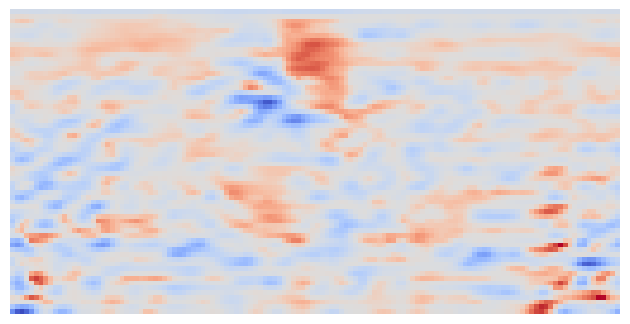

In [26]:
plt.imshow(x_rec_cae[..., 1].detach().cpu().numpy().T, origin='lower', cmap='coolwarm')
plt.axis('off')
plt.tight_layout()
x_diff_cae = x_rec_cae.detach().cpu() - xx_t
cae_err = np.mean(np.abs(x_diff_cae.detach().cpu().numpy()))
plt.savefig(os.path.join(save_path, 'CAE-vorticity-reconstruction.pdf'))
print(f'CAE reconstruction (vorticity) avg. absolute error: {cae_err:.4f}')

AEflow reconstruction (height) avg. absolute error: 0.5956


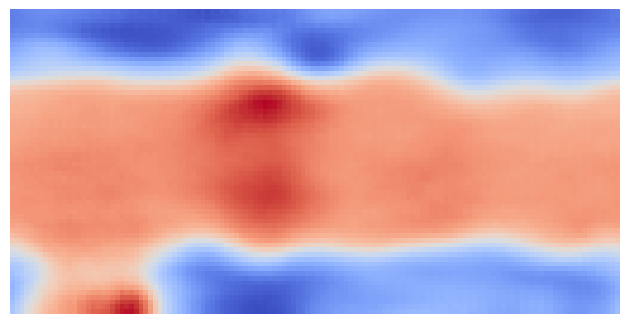

In [27]:
plt.imshow(x_rec_aeflow[..., 0].detach().cpu().numpy().T, origin='lower', cmap='coolwarm')
plt.axis('off')
plt.tight_layout()
x_diff_aeflow = x_rec_aeflow.detach().cpu() - xx_t
aeflow_err = np.mean(np.abs(x_diff_aeflow.detach().cpu().numpy()))
plt.savefig(os.path.join(save_path, 'AEflow-height-reconstruction.pdf'))
print(f'AEflow reconstruction (height) avg. absolute error: {aeflow_err:.4f}')

AEflow reconstruction (vorticity) avg. absolute error: 0.5956


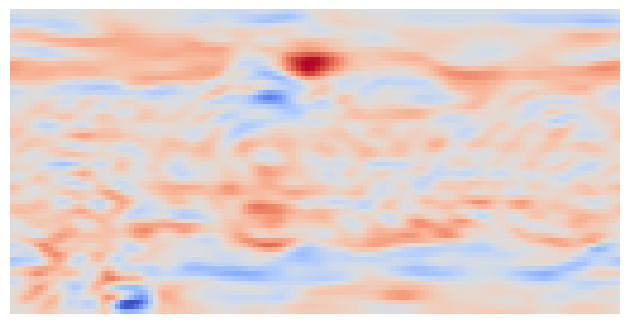

In [28]:
plt.imshow(x_rec_aeflow[..., 1].detach().cpu().numpy().T, origin='lower', cmap='coolwarm')
plt.axis('off')
plt.tight_layout()
x_diff_aeflow = x_rec_aeflow.detach().cpu() - xx_t
aeflow_err = np.mean(np.abs(x_diff_aeflow.detach().cpu().numpy()))
plt.savefig(os.path.join(save_path, 'AEflow-vorticity-reconstruction.pdf'))
print(f'AEflow reconstruction (vorticity) avg. absolute error: {aeflow_err:.4f}')

SINR reconstruction (height) avg. absolute error: 0.1672


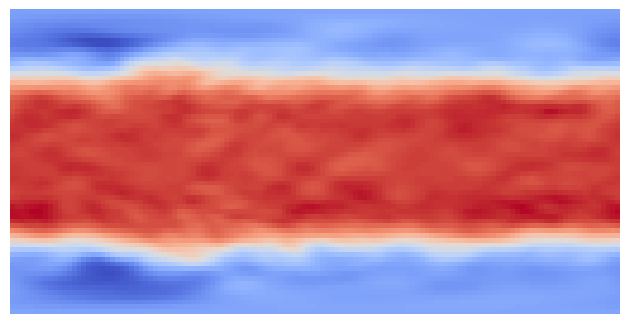

In [29]:
plt.imshow(x_rec_sinr[..., 0].detach().cpu().numpy().T, origin='lower', cmap='coolwarm')
plt.axis('off')
plt.tight_layout()
x_diff_sinr = x_rec_sinr.detach().cpu() - xx_t
sinr_err = np.mean(np.abs(x_diff_sinr.detach().cpu().numpy()))
plt.savefig(os.path.join(save_path, 'SINR-height-reconstruction.pdf'), bbox_inches='tight')
print(f'SINR reconstruction (height) avg. absolute error: {sinr_err:.4f}')

SINR reconstruction (vorticity) avg. absolute error: 0.1672


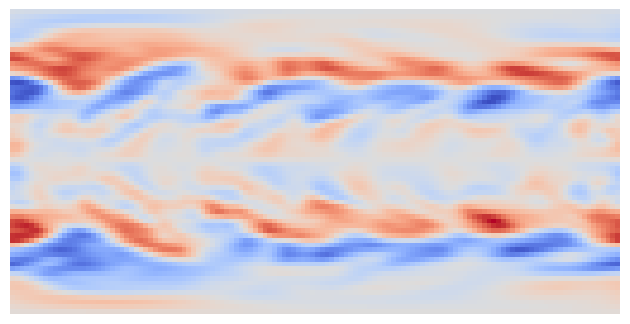

In [30]:
plt.imshow(x_rec_sinr[..., 1].detach().cpu().numpy().T, origin='lower', cmap='coolwarm')
plt.axis('off')
plt.tight_layout()
x_diff_sinr = x_rec_sinr.detach().cpu() - xx_t
sinr_err = np.mean(np.abs(x_diff_sinr.detach().cpu().numpy()))
plt.savefig(os.path.join(save_path, 'SINR-vorticity-reconstruction.pdf'), bbox_inches='tight')
print(f'SINR reconstruction (vorticity) avg. absolute error: {sinr_err:.4f}')